In [1]:
import tritonclient.grpc as grpcclient
import json
from PIL import Image, ImageDraw
from pillow_heif import register_heif_opener
import numpy as np

register_heif_opener()

In [2]:
model_name = "fpenet"
model_version = "1"
url = "172.25.0.42:8001"

facedetect_data_filename = "facedetect_data.json"

In [26]:
def parse_model_grpc(model_metadata, model_config):
    """
    Check the configuration of a model to make sure it meets the
    requirements for an image classification network (as expected by
    this client)
    """
    if len(model_metadata.inputs) != 1:
        raise Exception("expecting 1 input, got {}".format(len(model_metadata.inputs)))

    if len(model_config.input) != 1:
        raise Exception(
            "expecting 1 input in model configuration, got {}".format(
                len(model_config.input)
            )
        )

    input_metadata = model_metadata.inputs
    output_metadata = model_metadata.outputs

    return (input_metadata, output_metadata, model_config.max_batch_size)


def get_face_clip(img, image_wise_bboxes):
    image_wise_bboxes = np.array([int(eval(i)) for i in image_wise_bboxes])
    image = img.crop((image_wise_bboxes)).resize((80, 80))
    f_image = np.expand_dims(np.array(image, dtype="float32"), axis=0)

    return image, f_image


def submit_to_triton(image_data, input_name, output_names, request_id=None):

    inputs = [grpcclient.InferInput(input_name, image_data.shape, "FP32")]
    inputs[0].set_data_from_numpy(image_data)

    outputs = [
        grpcclient.InferRequestedOutput(output_name, class_count=0)
        for output_name in output_names
    ]
    return triton_client.infer(model_name, inputs, outputs=outputs)

In [27]:
triton_client = grpcclient.InferenceServerClient(url=url, verbose=False)

model_metadata = triton_client.get_model_metadata(
    model_name=model_name, model_version=model_version
)

model_config = triton_client.get_model_config(
    model_name=model_name, model_version=model_version
).config

input_metadata, output_metadata, max_batch_size = parse_model_grpc(
    model_metadata, model_config
)

In [28]:
max_workers = max_batch_size * model_config.instance_group[0].count

64

In [29]:
input_metadata

[name: "input_face_images"
datatype: "FP32"
shape: -1
shape: 1
shape: 80
shape: 80
]

In [30]:
output_names = [i.name for i in output_metadata]
output_metadata

[name: "conv_keypoints_m80"
datatype: "FP32"
shape: -1
shape: 80
shape: 80
shape: 80
, name: "softargmax"
datatype: "FP32"
shape: -1
shape: 80
shape: 2
, name: "softargmax:1"
datatype: "FP32"
shape: -1
shape: 80
]

In [31]:
with open(facedetect_data_filename) as f:
    facedetect_data = json.load(f)

In [32]:
pil_clips = []
fpenet_clips = []
for items in facedetect_data[:20]:
    if items["faces"][0]["probability"] != "0":
        image = Image.open(items["filename"]).convert("L")
        for face in items["faces"]:
            image_wise_bboxes = tuple(face["bbox"].values())
            pil_clip, fpenet_clip = get_face_clip(image, image_wise_bboxes)
            pil_clips.append(pil_clip)
            fpenet_clips.append(fpenet_clip)

In [33]:
results = submit_to_triton(
    np.stack(fpenet_clips), "input_face_images", output_names, request_id=None
)

In [34]:
results.as_numpy(output_names[0]).shape

(5, 80, 80, 80)

In [35]:
results.as_numpy(output_names[1]).shape

(5, 80, 2)

In [36]:
results.as_numpy(output_names[2]).shape

(5, 80)

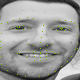

In [37]:
idx = 4
img = pil_clips[4].convert("RGB")
for x, y in results.as_numpy(output_names[1])[idx]:
    img.putpixel((x, y), (118, 185, 0))
img

In [25]:
results.as_numpy(output_names[0])[idx].shape

(80, 80, 80)